In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os, sys
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from utils import random_cv_split, int_col_to_string, string_col_to_int, load_gensim_model, encode_column


# Load Data

Read the data into a panda dataframe

Build training data using the not null data and a prediction set using the null data.

Then split up the training data into a training set and a cross validation set by randomly splitting items up by their program priority code.

In [2]:
df = pd.read_excel('data/LA_Budget_Data.xlsx')

In [3]:
for column in df.columns:
    
    nulls = df[column].isnull().any()
    print(column, "has nulls: ", nulls)


Dept_Code has nulls:  True
Department_Name has nulls:  False
SubDept_Code has nulls:  False
SubDepartment_Name has nulls:  False
Prog_Code has nulls:  True
Program_Name has nulls:  True
Program_Priority has nulls:  True
Source_Fund_Code has nulls:  True
Source_Fund_Name has nulls:  True
Account_Code has nulls:  True
Account_Name has nulls:  True
Appropriation has nulls:  False
Fiscal_Year has nulls:  False
Expense_Type has nulls:  True


In [4]:
decoders = {}


decoders["Department_Name"] = encode_column(df, "Department_Name")
decoders["SubDepartment_Name"] = encode_column(df, "SubDepartment_Name")

full_data = df[df["Expense_Type"].notnull()]
full_data = full_data.dropna(how='any')

encode_column(full_data, "Expense_Type")
encode_column(full_data, "Program_Priority")
encode_column(full_data, "Program_Name")
encode_column(full_data, "Account_Name")


empty_data = df[False == df["Expense_Type"].notnull()]


single_empty = empty_data[empty_data["Account_Name"].notnull()]
all_empty = empty_data[False == empty_data["Account_Name"].notnull()]

priorities = full_data["Program_Priority"].unique()
programs = full_data["Program_Name"].unique()
expenses = full_data["Expense_Type"].unique()
departments = full_data["Dept_Code"].unique()

guaranteed = ["Encoded_SubDepartment_Name", "Encoded_Department_Name", "Appropriation"]
not_guaranteed = ["Encoded_Program_Name", "Encoded_Program_Priority", "Encoded_Account_Name"]

all_keys = guaranteed + not_guaranteed

# Test a hardcoded method to serve as baseline

To me, it looks like the only guaranteed info for the rows that don't have expense type is the department name
and appropriation, so that's what i'll build the baseline model using.
Algorithm: For each row in the dataset find all other rows with the same department name. Then,
out of these rows, find the row that has the appropriation value closest to the current row's. Lastly,
check if the expense types are equal and add to accuracy score if so.

Possible Extensions: Find 'n' closest rows and then take a polling on their expense types when making final prediction.



In [80]:
#keep a count to keep track of current row
count = 0
#used for accuracy metric
num_total =0
num_correct = 0.0
#sometimes an error occurs when taking the mean, so I just keep track to make sure its no big deal
num_minargerr = 0


for index, row in full_data.iterrows():
    #current_rows appropriation
    approp_amount = row["Appropriation"]
    indexes = list(np.where(full_data["Department_Name"] == row["Department_Name"])[0])
    
    #remove current row from the search
    indexes = list(filter(lambda a: a != count, indexes))
    
    #search through rows that have same department name
    searching = full_data.iloc[indexes]
    searching_list = searching["Appropriation"].tolist()
    
    #sometimes searching_list is null and triggers an error
    try:
        #get row with closest appropriation amount
        closest_index = min(range(len(searching_list)), key=lambda i: abs(searching_list[i]-approp_amount))
        closest_row = searching.iloc[closest_index]
        
        if(row["Expense_Type"] == closest_row["Expense_Type"]):
            num_correct += 1
    except:
        num_minargerr +=1
    
    num_total += 1
    count+=1
print("Number of errors:", num_minargerr)
print("Accuracy:", num_correct/num_total)

Number of errors: 3
Accuracy: 0.7497718177350278


# Look For Easy Correlations

Other than Dept_Code and Program name, there don't appear to be any great correlations with Expense type. I'm not too optimistic about this approach, but let's see how it goes.

In [15]:
full_data.corr()

,Appropriation,Fiscal_Year,Encoded_Department_Name,Encoded_SubDepartment_Name,Encoded_Expense_Type,Encoded_Program_Priority,Encoded_Program_Name,Encoded_Account_Name
Appropriation,1.000000,0.017380,0.022168,0.041060,0.036633,0.008716,-0.004502,0.009344
Fiscal_Year,0.017380,1.000000,-0.138887,0.032914,-0.092946,-0.292256,0.038540,-0.023045
Encoded_Department_Name,0.022168,-0.138887,1.000000,0.530920,0.040165,-0.125534,0.138764,-0.032562
Encoded_SubDepartment_Name,0.041060,0.032914,0.530920,1.000000,0.075124,0.018711,0.071454,0.005377
Encoded_Expense_Type,0.036633,-0.092946,0.040165,0.075124,1.000000,0.054820,-0.025987,0.298865
Encoded_Program_Priority,0.008716,-0.292256,-0.125534,0.018711,0.054820,1.000000,0.011057,0.022938
Encoded_Program_Name,-0.004502,0.038540,0.138764,0.071454,-0.025987,0.011057,1.000000,-0.015946
Encoded_Account_Name,0.009344,-0.023045,-0.032562,0.005377,0.298865,0.022938,-0.015946,1.000000


# Try Random Forest

Try running data through a random forest classifier with various combinations to see how they work

In [34]:

#string_col_to_int("Dept_Code", departments, full_data)

def train_and_score_rfc(data, train_keys,  iterations=1):
    
    train, cv = random_cv_split(full_data)
    
    rfc_low = RandomForestClassifier(n_estimators=10)

    
    for i in range(iterations):
        rfc_low.fit(train[train_keys], train["Expense_Type"])
        score = rfc_low.score(cv[train_keys], cv["Expense_Type"])
        print("Keys: ", train_keys)
        print(" Acc: ", score )

    
    return rfc_low

rfc_g = train_and_score_rfc(full_data, guaranteed)
rfc_ng = train_and_score_rfc(full_data, not_guaranteed)

rfc_sg = train_and_score_rfc(full_data, guaranteed+["Encoded_Account_Name"])

Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation']
 Acc:  0.7325046040515654
Keys:  ['Encoded_Program_Name', 'Encoded_Program_Priority', 'Encoded_Account_Name']
 Acc:  0.9751581907663464
Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation', 'Encoded_Account_Name']
 Acc:  0.9888242142025612


So interesting results here: It seems that the best individual indicator is simply Appropriation which makes sense. Then is program name and not far behind Dept code. Last is program priority which makes sense because that was a complex description. So this is kind of good news because for about 200 rows, the only info we have is the dept code and appropriation, so for those rows which we can't run embeddings on, we can still get descent results, given the ~75% accuracy of the only guaranteed keys

Now I'm going to try a few combinations just to get a better feel for data

In [17]:
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation"])
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Priority", "Appropriation"])
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation", "Encoded_Department_Name"] )
rfc = train_and_score_rfc(full_data, ["Encoded_Program_Name", "Appropriation", 
                                      "Encoded_SubDepartment_Name", "Encoded_Department_Name", 
                                      "Encoded_Account_Name"] )
rfc_all = train_and_score_rfc(full_data, all_keys)

Keys:  ['Encoded_Program_Name', 'Appropriation']
 Acc:  0.7504097401077031
Keys:  ['Encoded_Program_Priority', 'Appropriation']
 Acc:  0.6121549524472281
Keys:  ['Encoded_Program_Name', 'Appropriation', 'Encoded_Department_Name']
 Acc:  0.7952515279736718
Keys:  ['Encoded_Program_Name', 'Appropriation', 'Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Encoded_Account_Name']
 Acc:  0.9800092980009298
Keys:  ['Encoded_SubDepartment_Name', 'Encoded_Department_Name', 'Appropriation', 'Encoded_Program_Name', 'Encoded_Program_Priority', 'Encoded_Account_Name']
 Acc:  0.9722418254528347


So the best combination is essentially all the keys minus program priority which is something to keep in mind for later. I'm interested to see how the random forest results differ with embedding as opposed to unique values.

Random Forest was my first instinct to try on this data but I'm gonna try an SVM just in case it is closer to being linearly separablee

# View the Decision Breakdown

I'm going to plot the decision breakdown of the guaranteed and not guaranteed rfc to see if they lend any insights

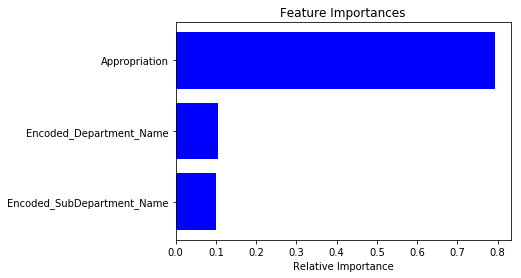

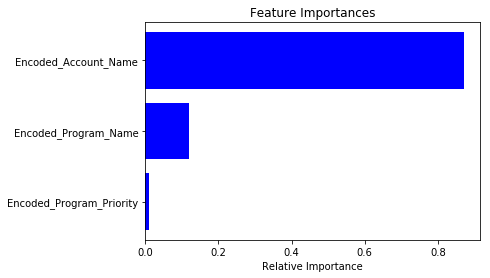

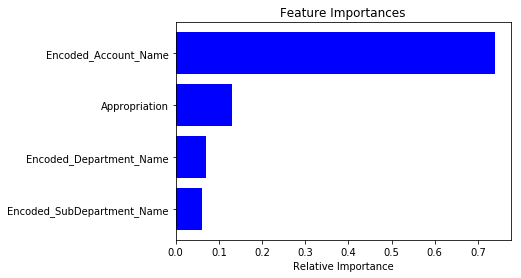

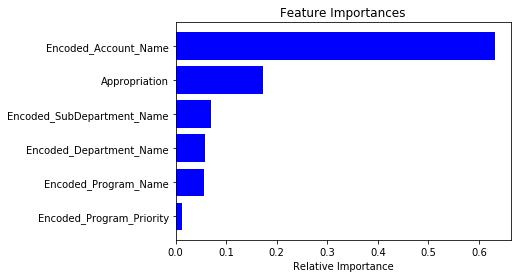

In [35]:
def plot_rfc_weights(forest, columns, fig_num=1):
    
    importances = forest.feature_importances_
    columns=np.array(columns)

    indices = np.argsort(importances)

    plt.figure(fig_num)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), columns[indices])
    plt.xlabel('Relative Importance')

    return

plot_rfc_weights(rfc_g, guaranteed, 1)
plot_rfc_weights(rfc_ng, not_guaranteed, 2)
plot_rfc_weights(rfc_sg, guaranteed + ["Encoded_Account_Name"], 3)
plot_rfc_weights(rfc_all, all_keys, 4)

# TakeAway

So, unsurprisingly, the Appropriation ammmount is by far the most considered part of the data, followed by the program name. I'm gonna try to do some more work with the program name to extract more information from it later on

In [5]:
from sklearn import svm


def train_and_score_svc(data, iterations=1):
    
    train, cv = random_cv_split(full_data)
    
    svc_g = svm.SVC()
    svc_ng = svm.SVC()
    
    for i in range(iterations):

        svc_g.fit(train[guaranteed], train["Expense_Type"])
        score = svc_g.score(cv[guaranteed], cv["Expense_Type"])
        print("SVC guaranteed data Score: ", score)


        svc_ng.fit(train[guaranteed+not_guaranteed], train["Expense_Type"])
        score = svc_ng.score(cv[guaranteed+not_guaranteed], cv["Expense_Type"])
        print("SVC not guaranteed data Score: ", score)
    
    
    return svc_g, svc_ng

svc_g, svc_ng = train_and_score_svc(full_data)


SVC guaranteed data Score:  0.678579456057541
SVC not guaranteed data Score:  0.6603731175545067


In [526]:
fa = full_data["Account_Name"].unique()
ea = single_empty["Account_Name"].unique()

ea = ea[1:]

only_ea = np.setdiff1d(ea,fa)

print("Number of empty data accounts", len(ea))
print("Number of empty data accounts not in full data", len(only_ea))

Number of empty data accounts 809
Number of empty data accounts not in full data 808


In [85]:
ea

array(['Gang Reduction and Youth Development Office (2)',
       'Lifeline Reimbursement Program (8)',
       'Clean Streets - Related Costs (3)',
       'Council Community Projects (4)',
       'Solid Waste Fee Reimbursement (10)',
       'Domestic Abuse Response Teams (5)',
       'Gang Injunction Curfew Settlement Agreement (7)',
       'Justice Fund (15)', 'Special Events Fee Subsidy - Citywide (11)',
       'embRACE LA', 'Census Operations and Outreach (2)',
       'FUSE Corps Fellows (6)',
       'Heritage Month Celebration & Special Events (13)',
       'World Police and Fire Games (2)', 'Aging Programs Various (2)',
       'Crisis Response Team (2)', 'Office of Re-entry (2)',
       'Cultural, Art and City Events (12)', 'Hot Weather Program',
       'Independent Cities Association (14)',
       'California Contract Cities (14)', 'Rapid Re-Housing Vouchers',
       'Family Source Centers', 'LA RISE',
       'Permanent Supportive Housing Environmental Impact Report',
       'LAHS

Not as good results as Random Forest, but it might scale better. With a smaller dataset I might use svm, but becasue we have around 80% of the data already filled and 20% not filled, I'm leaning towards the random forest

Also, SVM performs worse given the program name and ID, because it probably just adds unneccessary complexity towards the fitting.

# TRY SOME WORD2VEC STUFF

A major idea in NLP is the idea that word can be encoded into a vector space. Something interesting about this vector space, however, is that the difference in values (i.e. distance) between similar words and phrases will be smaller than the difference in values between dissimilar words. I'm going to try to leverage these encodings to see if there is a greater theme in either program priority or program names and the expense types

In [234]:
import gensim
from gensim.models import word2vec
import logging, urllib.request, zipfile

Download and load training data

# Train Gensim

We have to first train Gensim on data in order to load the word2vec of our data. These are some functions to read the zipfile, extract the zipfile, train gensim, and finally save the model under 'mymodel' so we don't have to retrain every time

I did packaged all this into a load_gensim_model function which takes in a root path to search for the data and model. If it finds the model it loads it, otherwise, it reads the data, trains the model, saves the model and returns the model. You can read the code in my utils.py file

In [38]:
model = load_gensim_model(os.getcwd()+"/data/")

Since gensim only allows for word2vec, I need to make a module that can read a string of words and return the average of all the vectors

I then have another function that applies this sentence2vec function to an entire column of a pandas dataframe.

In [40]:
dim = 300

def sentence2vec(words):
    """
    Module that converts takes in a string 
    with multiple words, takes the word2vec
    of each word, and then averages them all
    to get a sentence to vec
    
    For this dataset, no tf-idf is needed
    because no word appears twice in a single sentance
    """
    
    avg_vec = np.array([
                    np.mean([model.wv[w] for w in words.split() if w in model.wv]
                            or [np.zeros(dim)], axis=0)
                ]).reshape([300])
    return avg_vec


def get_vector_column(column_name, keys, df):
    
    vector_keys = []
    
    for key in keys:

        vector_keys.append(sentence2vec(key))
    
    col = np.zeros( [df.shape[0], 300] )
    
    for i, key in enumerate(keys):
        index = df[column_name] == key
        
        index = index.values.reshape([df.shape[0], 1])
        
        
        index = np.repeat(index, 300, axis=1)
        
        np.place(col, index, vector_keys[i])
        
    return col


    

# More Data Preparations

Now, I want to prepare training data for a deep learning approach. My plan is to have 2 different models to train. 1 that only accepts the guaranteed information i.e. the department and the appropriation and tries to predict the expense type. Another that takes in the department, appropriation and the sentence vector describing the department. I have 2 functions below used to build up the corresponding datasets.

In [466]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
    
def one_hot_Y(Y):
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(Y)
    
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    
    return onehot_encoded, label_encoder
    
def build_train_set(df, columns):
    
    name_vectors = get_vector_column("Account_Name", programs, df)
    
    X_data = df[columns].values
    
    Y = df["Expense_Type"].values
    
    Y, decoder = one_hot_Y(Y)
    
    return name_vectors, X_data, Y, decoder


name_vectors, train_data, Y, decoder = build_train_set(full_data, guaranteed)

/home/kian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


# Time Set up the Models

In [42]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Concatenate


/home/kian/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Start Slow

First I'm going to start out with a basic model that only accepts the guaranteed information. This will provide a good baseline for future models 

In [52]:
basic_model = Sequential()

in_shape = (3,)

basic_model.add(Dense(128, input_shape=in_shape, activation='relu' ))
basic_model.add(Dense(256, activation='relu'))
basic_model.add(Dense(len(expenses), activation='softmax'))

basic_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

basic_model.fit(train_data, Y, epochs=3)

Epoch 1/3
14243/14243 [==============================] - 1s 62us/step - loss: 7.8248 - acc: 0.4792
Epoch 2/3
14243/14243 [==============================] - 1s 57us/step - loss: 7.7219 - acc: 0.4794
Epoch 3/3
14243/14243 [==============================] - 1s 53us/step - loss: 7.6174 - acc: 0.4866


# Takeaway

So unsurprisingly, the model can't even fit the training set much above 50%, much less a test set. I don't see much gain by hyper-parameter tinkering at this point. I think the route to take with the only guaranteed data filling in is just using the random forest. Now I'm gonna try out the non-guaranteed data sentance encoding to see if it helps much. I don't have great hopes, but it's worth a try :)

In [468]:
big_X = np.concatenate([train_data, name_vectors], axis=1)

bigger_model = Sequential()

in_shape = (303,)

bigger_model.add(Dense(128, input_shape=in_shape, activation='relu' ))
bigger_model.add(Dense(256, activation='relu'))
bigger_model.add(Dense(len(expenses), activation='softmax'))

bigger_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
bigger_model.fit(big_X, Y, epochs = 10)

Epoch 1/10
14243/14243 [==============================] - 1s 76us/step - loss: 1.0965 - acc: 0.5419
Epoch 2/10
14243/14243 [==============================] - 1s 76us/step - loss: 1.0466 - acc: 0.5469
Epoch 3/10
14243/14243 [==============================] - 1s 76us/step - loss: 1.0641 - acc: 0.5508
Epoch 4/10
14243/14243 [==============================] - 1s 77us/step - loss: 1.0414 - acc: 0.5595
Epoch 5/10
14243/14243 [==============================] - 1s 77us/step - loss: 1.1108 - acc: 0.5574
Epoch 6/10
14243/14243 [==============================] - 1s 77us/step - loss: 1.1610 - acc: 0.5573
Epoch 7/10
14243/14243 [==============================] - 1s 79us/step - loss: 1.0961 - acc: 0.5632
Epoch 8/10
14243/14243 [==============================] - 1s 79us/step - loss: 1.1869 - acc: 0.5608
Epoch 9/10
14243/14243 [==============================] - 1s 79us/step - loss: 1.2386 - acc: 0.5627
Epoch 10/10
14243/14243 [==============================] - 1s 79us/step - loss: 1.1636 - acc: 0.5587

# Last DL Effort

So the last few efforts didn't go very well, so I'm gonna try 1 more task. I'm gonna try to run the word encodings through a FC encoder, then concatenate that with the other data, and then make a prediction

But, given the small sample size and wide variety of uncorrelated inputs, I didn't think this was a problem well suited for deep learning. I was more interested in whether the vectorization of the sentences would show any improvements over the baseline but it did not seem to

In [76]:
vec = Input(shape=(300,))

enc1 = Dense(128, activation='relu')(vec)
enc2 = Dense(64, activation='relu')(enc1)
enc3 = Dense(5, activation='relu')(enc2)

data = Input(shape=(3,))

full_data = Concatenate()([vec, data])

fc1 = Dense(64, activation='relu')(full_data)
fc2 = Dense(128, activation='relu')(fc1)
output = Dense(len(expenses), activation='softmax')(fc2)

final_model = Model([vec, data], output)

final_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [86]:
final_model.fit([name_vectors, train_data], Y, epochs=10)

Epoch 1/10
14243/14243 [==============================] - 1s 55us/step - loss: 0.9880 - acc: 0.5496
Epoch 2/10
14243/14243 [==============================] - 1s 53us/step - loss: 1.0026 - acc: 0.5467
Epoch 3/10
14243/14243 [==============================] - 1s 53us/step - loss: 1.0054 - acc: 0.5495
Epoch 4/10
14243/14243 [==============================] - 1s 53us/step - loss: 0.9893 - acc: 0.5562
Epoch 5/10
14243/14243 [==============================] - 1s 55us/step - loss: 1.0311 - acc: 0.5621
Epoch 6/10
14243/14243 [==============================] - 1s 54us/step - loss: 1.0386 - acc: 0.5621
Epoch 7/10
14243/14243 [==============================] - 1s 55us/step - loss: 0.9755 - acc: 0.5536
Epoch 8/10
14243/14243 [==============================] - 1s 55us/step - loss: 1.0276 - acc: 0.5688
Epoch 9/10
14243/14243 [==============================] - 1s 55us/step - loss: 1.0043 - acc: 0.5686
Epoch 10/10
14243/14243 [==============================] - 1s 59us/step - loss: 1.0463 - acc: 0.5625

# As Expected, Neural Nets are not the way to go

There are so many different inputs and there is such little correlation between the various word2vec inputs to the result, DL is not the way to go.

I'm going to try some other methods to fit the data they won't have too much fruition

Building a cv splitting function for a cross validation set randomly

In [475]:
def np_cv_split(x, y):
    
    index = np.random.rand(x.shape[0]) > .5
    
    train_x = x[index]
    train_y = y[index]
    
    cv_x = x[False == index]
    cv_y = y[False == index]
    
    return train_x, train_y, cv_x, cv_y 

train_x, train_y, cv_x, cv_y = np_cv_split(big_X, Y)

# Try to fit data using SVM

I'm not expecting much better results than the Network, but por favor prove me wrong :)

In [474]:


svc = svm.SVC()

svc.fit(train_x, train_y.argmax(axis=1))

svc.score(cv_x, cv_y.argmax(axis=1))

0.6774569166278528

# Try RFC

I don't think RFC will perform much better than the baseline because of all the extra noise the word2vec data provides. Again- por favor prove me wrong :)

In [476]:
rfc_low = RandomForestClassifier(n_estimators=30)

rfc_low.fit(train_x, train_y)
score = rfc_low.score(cv_x, cv_y)
print(" Acc: ", score )

 Acc:  0.7137045868985833


As I suspected, none of these performed better than the baseline model. I think the reason for this decrease in performance, despite the increase in information, is that the word2vec model, even if it provides some relevent information to the prediction, it provides so much information that these various models, especially ensemble models such as RFC and NNs will be able to find a number of "correlations" that are coincidental in our data, and have no actually effect on predicting expense type

# N-Grams

So, I realized, looking back through the data, I really just wanted to quantify certain keyword phrases. In order to reach this quantification, without bring on all the extra garbage of word2vec, I'm going to instead create a one-hot vectorization of N-grams, in order to detect the presence or abscence of certain key-words or phrases

Creating bi-gram data, and concatenating with the guaranteed data

In [166]:
from sklearn.feature_extraction.text import CountVectorizer

account_names = full_data["Account_Name"].tolist()
make_ngram = CountVectorizer()

n_grams = make_ngram.fit_transform(account_names).toarray()

other_data = full_data[guaranteed].as_matrix()

X = np.concatenate([other_data, n_grams], axis=1)

Creating an index that separates a certain number of entire account names- thus, the account names in our test set will have never appeared in our training set. This will allow us to get an accurate determination as to how it will perform on the new data

In [173]:

unique = full_data["Account_Name"].unique()

index = np.random.rand(unique.shape[0]) > .3

training_accounts = set(unique[index])
test_accounts = set(unique[False == index])

def in_training(x):
    return x in training_accounts

index = full_data["Account_Name"].apply(in_training)


def account_cv_split(x, y, index):
    
    
    train_x = x[index]
    train_y = y[index]
    
    cv_x = x[False == index]
    cv_y = y[False == index]
    
    return train_x, train_y, cv_x, cv_y 


X_train, Y_train, X_test, Y_test = account_cv_split(X, full_data["Expense_Type"], index)

# Visualize To Featurpe Weights

Get a list of the feature weights of the best scoring rfc for assessment

In [174]:
def plot_ngram_rfc(rfc, fignum, acc):

    cols = range(303)

    features_and_weights = sorted(zip(map(lambda x: round(x, 4), rfc_keep.feature_importances_), cols), 
                 reverse=True)

    important_phrases = []
    weights = []

    for pair in features_and_weights[0:30]:
        one_hot = np.zeros([300])
        one_hot[pair[1]-3] = 1
        phrase = make_ngram.inverse_transform(one_hot)[0]
        phrase = " ".join(phrase.tolist())

        important_phrases.append(phrase)
        weights.append(pair[0])


    plt.figure(num=fignum, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Acc:'+ str(acc) )
    plt.barh(range(len(weights)), weights, color='b', align='center')
    plt.yticks(range(len(important_phrases)), important_phrases)
    plt.xlabel('Relative Importance')


# Random Forest Attempt

So random forest is gave good results, but also wildly fluctuated based on the random state: in order to combat this inconsistency, I set max features from sqrt to log2, and increased the estimators

Random State  47 Accuracy:  0.829126213592233
Random State  87 Accuracy:  0.8207119741100324
Random State  56 Accuracy:  0.8401294498381877


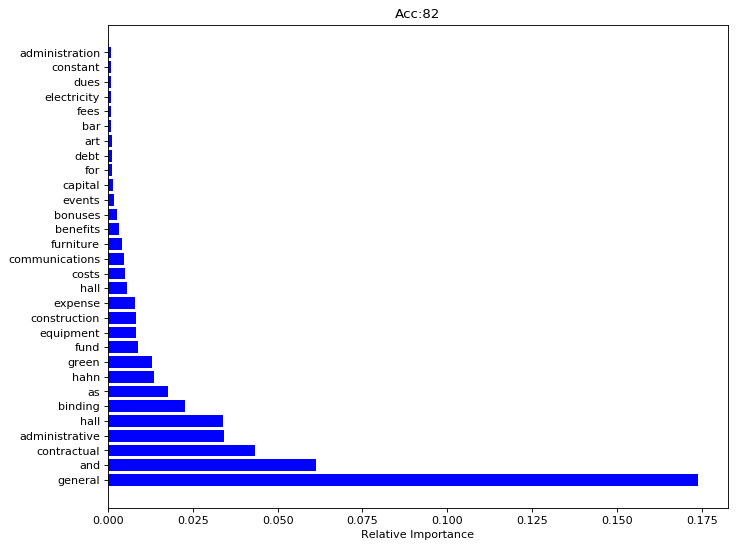

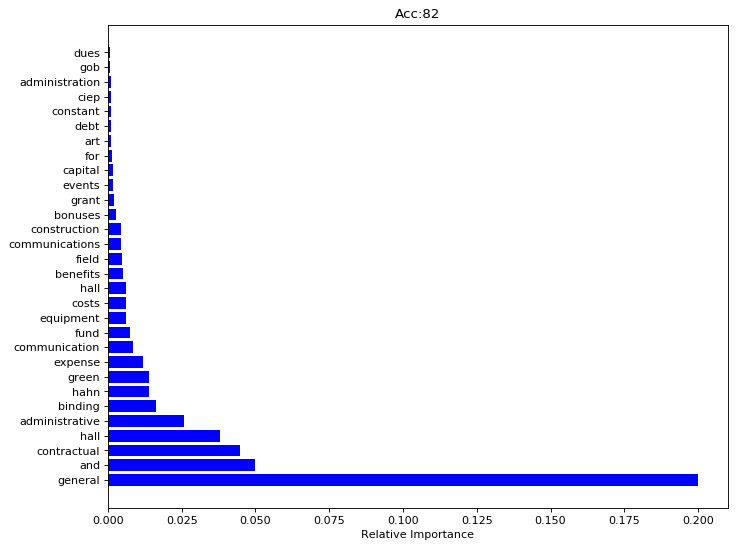

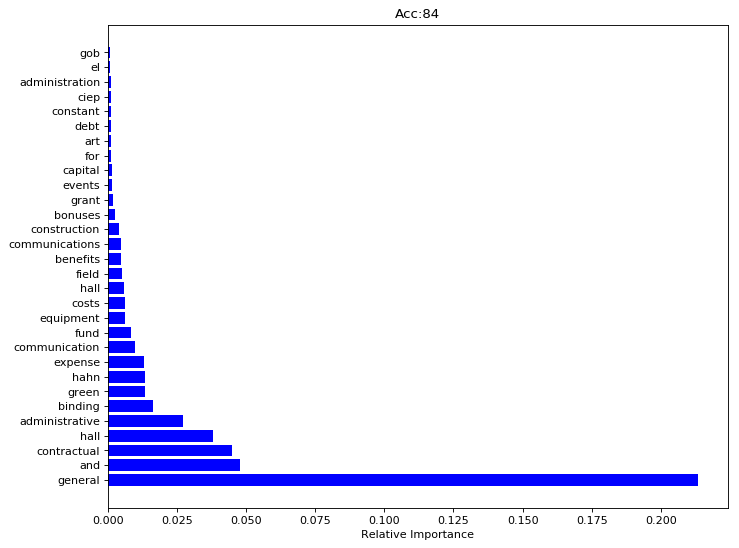

In [170]:
from random import random

max_accuracy = 0

for i in range(3):
    
    state = int(random()*100) 
    
    rfc = RandomForestClassifier(n_estimators=500, random_state=state, max_features='log2')

    rfc.fit(X_train, Y_train)
    
    acc = rfc.score(X_test, Y_test)
    
    plot_ngram_rfc(rfc, i, int(100*acc))
    
    if acc > max_accuracy:
        rfc_keep = rfc

    print("Random State ", state, "Accuracy: ", acc)
    

So I'm a little surprised at the importances of some words: not too much at others

## Create a training set of only the Important columns

There are a number of columns that are barely weighted by the RFC- I'm going to see what happens to accuracy when these columns are removed

In [171]:
features_and_weights = sorted(zip(map(lambda x: round(x, 4), rfc_keep.feature_importances_), cols), 
                 reverse=True)

useful_feature_cols = []

# get col # of all useful features
for pair in features_and_weights:
    if pair[0] > .0001:
        useful_feature_cols.append(pair[1])

useful_feature_cols.sort()


compressed_features = []
for i in range(X.shape[0]):
    mini_hot = []
    for col in useful_feature_cols:
        mini_hot.append(X[i][col] )
        
    compressed_features.append(mini_hot)

X_important = np.array(compressed_features)

X_imp_train, Y_imp_train, X_imp_test, Y_imp_test = account_cv_split(X_important, full_data["Expense_Type"], index)

# Train the model and see how it improves

Random State  95 Important Data Accuracy:  0.4090614886731392
Random State  95 Full Data Accuracy:  0.8472491909385114
Random State  22 Important Data Accuracy:  0.4084142394822006
Random State  22 Full Data Accuracy:  0.8239482200647249
Random State  56 Important Data Accuracy:  0.39870550161812296
Random State  56 Full Data Accuracy:  0.8401294498381877


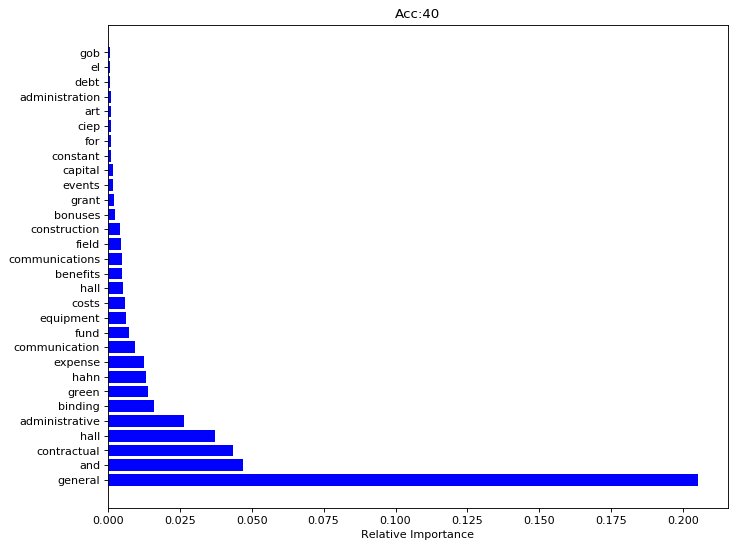

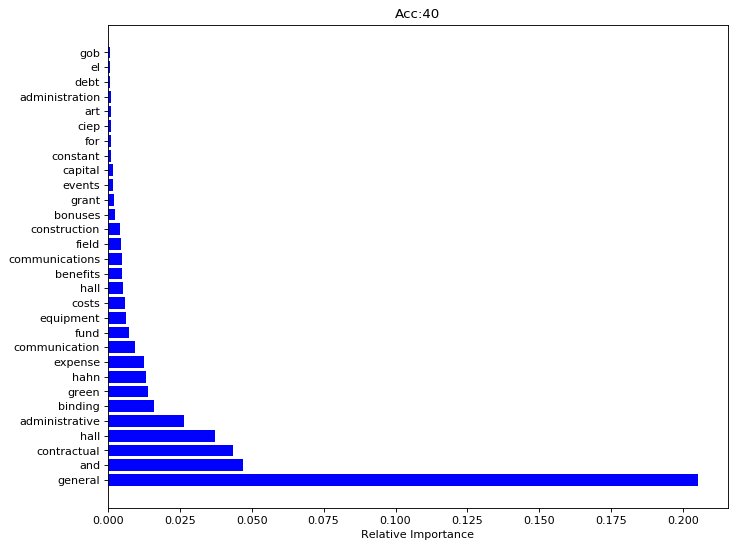

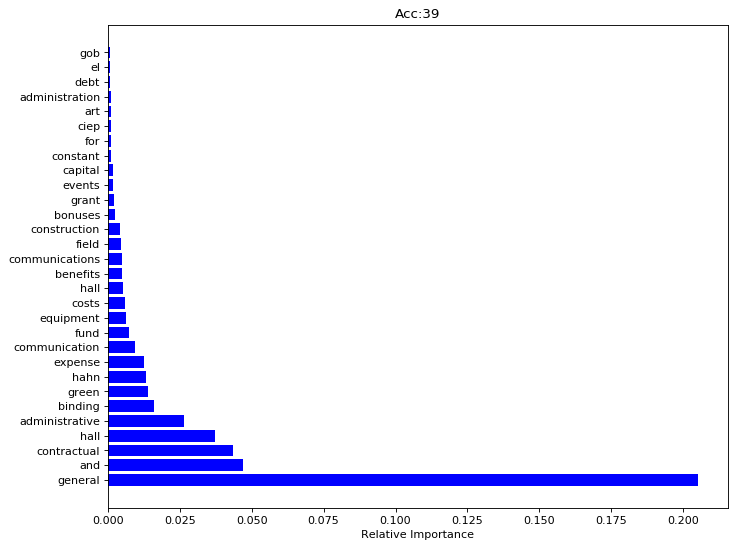

In [172]:
from random import random

max_accuracy = 0

for i in range(3):
    
    state = int(random()*100) 
    
    rfc = RandomForestClassifier(n_estimators=500, random_state=state, max_features='log2')
    
    # get results of full data
    rfc = RandomForestClassifier(n_estimators=500, random_state=state, max_features='log2')
    rfc.fit(X_train, Y_train)
    acc = rfc.score(X_test, Y_test)
    print("Random State ", state, "Full Data Accuracy: ", acc)
    plot_ngram_rfc(rfc, 2*i)
    
    # get results of only important data
    rfc.fit(X_imp_train, Y_imp_train)
    acc = rfc.score(X_imp_test, Y_imp_test)
    print("Random State ", state, "Important Data Accuracy: ", acc)
    plot_ngram_rfc(rfc, 2*i+1, int(100*acc))

# Boosted Decision Tree

Because of the inconsistencies with the decision tree, I think there is too high of a potential to have a bad split to confidently use a decision tree on the data and be confident about the accuracy. I think the reason for this is that there are so many different categories, a large number of which do not matter too much. In order to combat this, I'm going to try instead a boosted tree, which will run through every node and simply correct its previous attempts

In [535]:
from sklearn.ensemble import AdaBoostClassifier

gbt = AdaBoostClassifier(n_estimators=50, learning_rate=.5)

gbt.fit(X_train, Y_train)

gbt.score(X_test, Y_test)

0.5962199312714777

So this actually scored consistently far worse than the random forest- I honestly was not sure how much the gradient boosting would help vs random sampling

# SVM

I'm pretty sure that this data is, again, way too broad to be fit by

In [9]:
svc = svm.SVC()

svc.fit(X_train, Y_train)

score = svc.score(X_test, Y_test)

print("Accuracy: ", score)

Accuracy:  0.631578947368421
